# Reproduce: Wave-Function Approach to Dissipative Processes in Quantum Optics

J. Dalibard and Y. Castin, <a href="http://dx.doi.org/10.1103/PhysRevLett.68.580">Phys. Rev. Lett. <b>68</b>, 580 (1992).</a>

Reproduced by <strong>Eunjong Kim</strong> (ekim7206@gmail.com)

This paper introduces the <strong>Monte-Carlo wave-function (MCWF)</strong> approach and proves its equivalence with the Optical Bloch equation (OBE). In this notebook, I will briefly summarize the main points and reproduce the figures in the paper generated by numerical calculations.

## Setup Modules

In [1]:
import numpy as np
import qutip as qt

In [2]:
# setup for plots
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams.update({"text.usetex": True, "font.size": 16})

## Monte-Carlo wave-function (MCWF) approach

Consider a two-level atom, with a ground state $|g\rangle$ and an excited state $|e\rangle$, coupled to a monochromatic laser field and to the quantized electromagnetic field in its ground state.

Describing the laser field as a classical function $\mathcal{E} (t) = \mathcal{E}_0 \cos{\omega_L t}$, the atom-laser coupling Hamiltonian under the rotating-wave approximation is written as ($\hbar = 1$)
$$
H_0 = -\delta \sigma_+ \sigma_- + \Omega (\sigma_+ + \sigma_-),
$$
where $\sigma_+ = |e\rangle\langle g|$, $\sigma_- = (\sigma_+)^\dagger$, and $\delta = \omega_L - \omega_A$ is thedetuning between the laser and atomic frequencies; $\Omega = -d\mathcal{E}_0$ is the Rabi frequency that characterizes the coupling between the atomic dipole moment $d$ and the laser electric field.

We assume that the total system involving the atom and the quantized field at the time $t$ is represented by the wavefunction
$$
|\psi(t)\rangle = |\phi(t)\rangle \otimes |0\rangle = (\alpha_g |g\rangle + \alpha_e |e\rangle) \otimes |0\rangle,
$$
where $|0\rangle$ denotes the vacuum state of the quantized electromagnetic field.

After a short time step of $dt$, during which at most one photon can be spontaneously emitted ($dt\ll \Gamma^{-1}, \Omega^{-1}, \delta^{-1}$), the wavefunction can be decomposed into two parts: $|\psi(t+dt)\rangle = |\psi^{(0)}(t+dt)\rangle + |\psi^{(1)} (t+dt)\rangle$, where
$$|\psi^{(0)}(t+dt)\rangle = (\alpha'_g |g\rangle + \alpha'_e |e\rangle) \otimes |0\rangle$$
is the non-decaying part and
$$|\psi^{(1)}(t+dt)\rangle = |g\rangle \otimes \sum_{\mathbf{k},\epsilon}\beta_{\mathbf{k},\epsilon} |\mathbf{k},\epsilon\rangle$$
is the decaying part.

Note that $dp = \Gamma dt |\alpha_e|^2= \Gamma dt \langle \phi(t)|\sigma_+\sigma_-|\phi(t)\rangle$ corresponds to the spontaneously decayed population at time $t+dt$, $$\langle\psi^{(1)}(t+dt)|\psi^{(1)}(t+dt)\rangle = dp$$
and thus $$\langle\psi^{(0)}(t+dt)|\psi^{(0)}(t+dt)\rangle = 1 - dp$$

To obtain the values of $\alpha'_g$ and $\alpha'_e$, the evolution of $|\phi(t)\rangle$ during $dt$ with the non-Hermitian Hamiltonian is introduced, where
$$ H = H_0 - \frac{i\Gamma}{2} \sigma_+ \sigma_-.$$
This amounts to reducing the excited-state amplitude by a factor $1- \Gamma dt/2$.

For the Monte-Carlo approach, the following scheme is prepared:
1. All spontaneous photons are detected with a perfect counter and we measure the number of photons at time $t+dt$.
2. Depending on the result $0$ or $1$ of the measurement, we have to project $|\psi(t + dt)\rangle$ on $|\psi^{(0)}(t + dt)\rangle$ or $|\psi(t + dt)^{(1)}\rangle$ and normalize the result. This could be done using a pseudo-random number $0<\epsilon<1$: <br>
(i) $\epsilon > dp$ corresponds to zero photon detection, which collapses $|\psi(t+dt)\rangle$ onto
$$\frac{|\psi^{(1)}(t+dt)\rangle}{\sqrt{\langle\psi^{(1)}(t+dt)|\psi^{(1)}(t+dt)\rangle}} = \frac{1}{\sqrt{1-dp}} (1-i dt\ H)|\phi(t)\rangle \otimes |0\rangle$$
(ii) $\epsilon < dp$ corresponds to one photon detection, which collapses $|\psi(t+dt)\rangle$ onto $|g\rangle\otimes|0\rangle$. Note that the detected photon has been destroyed after the gedanken measurement process.
3. Now, since we returned to a wavefunction in the form of $|\psi(t+dt)\rangle = |\phi(t+dt)\rangle \otimes |0\rangle$, we can go back to the steps 1-2 repeatedly.


In the paper, the authors show that this Monte-Carlo wave-function (MCWF) approach is equivalent to the standard master equation approach, also known as the Optical Bloch Equation (OBE). I skip that argument in this notebook and numerically calculate the example to reproduce Figure 1 in the original article.

## Example: Rabi transitory regime

In [3]:
sm, sp = qt.sigmam(), qt.sigmap()

In [4]:
# Parameters
Gamma = 1.0               # decay rate
delta = 0.0               # detuning
Omega = 3.0 * Gamma       # Rabi frequency

In [5]:
# atom-laser coupling hamiltonian within the rotating-wave approximation
H0 = - delta * sp * sm + Omega * (sp + sm)

# non-Hermitian Hamiltonian introduced to reduce the excited-state amplitude
H = H0 - 1j * Gamma * sp * sm /2

In [6]:
N = 2
ground = qt.basis(N, 1)   # atom initially in the ground state

In [7]:
dt = 1e-2                 # unit time step for Monte-Carlo approach
t = np.arange(0, 4, dt)   # 
phi0 = ground             # initial state
M = 100                   # number of systems to be averaged

In [8]:
populations = []

for m in range(100):        # repeat for M systems
    phi = [phi0]
    population = []
    for idx in range(len(t)):
        dp = Gamma * dt * qt.expect(sp * sm, phi[-1])
        mu = 1 / np.sqrt(1 - dp)
        # random number generation
        epsilon = np.random.random()
        if epsilon > dp:  # collapse onto detection of 0 photon
            phi_ = mu * (1 - 1j * dt * H) * phi[-1]
            phi.append(phi_.unit())  # normalization after evolution
        else:             # collapse onto detection of 1 photon
            phi.append(ground)
        population.append(qt.expect(sp * sm, phi[-1]))
    populations.append(np.array(population))

In [9]:
# Result obtained from the Optical Bloch Equation (OBE) using qutip mesolver
OBE_result = qt.mesolve(H0, phi0, t, [np.sqrt(Gamma) * sm], [sp * sm])

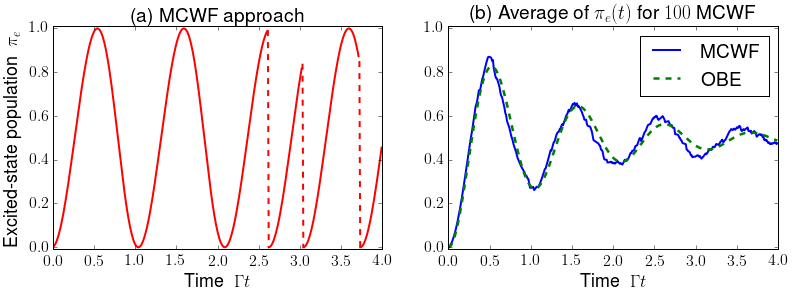

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))

pop0 = np.copy(populations[-1])
# mark the points at the discontinuity and connect with dashed lines
mask = np.where(np.abs(np.diff(pop0)) >= 1e-1)[0]
for mask_ in mask:
    axes[0].plot([t[mask_], t[mask_+1]], [pop0[mask_], pop0[mask_+1]], ls='--', color='red', lw=2)

pop0[mask] = np.nan
axes[0].plot(t, pop0, ls='-', color='red', lw=2)
axes[0].set_ylabel(r'Excited-state population $\ \pi_e$', fontsize=18)

axes[1].plot(t, sum(populations) / len(populations), ls='-', color='blue', lw=2, label='MCWF')
axes[1].plot(t, OBE_result.expect[0], ls='--', color='green', lw=2.5, label='OBE')

axes[0].set_ylim([-0.01, 1.01]); axes[1].set_ylim([-0.01, 1.01])
axes[0].set_title('(a) MCWF approach')
axes[1].set_title(r'(b) Average of $\pi_e(t)$ for $%d$ MCWF' % M)
axes[0].set_xlabel(r'Time $\ \Gamma t$', fontsize=18)
axes[1].set_xlabel(r'Time $\ \Gamma t$', fontsize=18)

axes[1].legend(loc=0);

The result of averaged MCWF clearly agrees the OBE result.

## Version Information

In [2]:
%reload_ext version_information

%version_information numpy, qutip

Software versions
Python 3.4.3 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.56)]
IPython 3.2.1
OS Darwin 14.5.0 x86_64 i386 64bit
numpy 1.9.2
qutip 3.2.0.dev-a76dc60
Wed Nov 11 16:23:04 2015 KST